# Evluating the embeddings
Loading of the data, adding the features to <italics>original_features<italics> and the training of the model is done using this link: https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from Timestamp2Vec_Model.helper_functions import *
from Timestamp2Vec_Model.Timestamp2Vec import *

SEED = 123

<Figure size 432x288 with 0 Axes>

## Data preparation

### Loading the data
Loading the Medical Appointment No Shows Data Set, from this link https://www.kaggle.com/datasets/joniarroba/noshowappointments

### Creating features for timestamps vectorized by Timestamp2Vec

In [2]:
data_location = os.path.join(os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop'), 'data_thesis')

# load the data
df = pd.read_csv(data_location + "/KaggleV2-May-2016.csv")

In [3]:
timestamp2vec = Timestamp2Vec()

In [4]:
scheduled_day_vector = timestamp2vec(df["ScheduledDay"])
apppointment_day_vector = timestamp2vec(df["AppointmentDay"])
diff_day = apppointment_day_vector - scheduled_day_vector

In [5]:
for i in range(scheduled_day_vector.shape[-1]):
    df["latent_var" + str(i + 1) + "_scheduled"] = scheduled_day_vector[:, i]
    df["latent_var" + str(i + 1) + "_appointment"] = apppointment_day_vector[:, i]
    df["latent_var" + str(i + 1) + "_delta"] = diff_day[:, i]

### Extracting features according to the link

In [6]:
df["OUTPUT_LABEL"] = (df["No-show"] == ("Yes")).astype(int)

df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"], format = "%Y-%m-%dT%H:%M:%SZ", errors = "coerce")
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"],  format = "%Y-%m-%dT%H:%M:%SZ", errors = "coerce")
df["AppointmentDay"] = df["AppointmentDay"] +pd.Timedelta("1d") - pd.Timedelta("1s")

In [7]:
df["ScheduledDay_year"] = df["ScheduledDay"].dt.year
df["ScheduledDay_month"] = df["ScheduledDay"].dt.month
df["ScheduledDay_week"] = df["ScheduledDay"].dt.week
df["ScheduledDay_day"] = df["ScheduledDay"].dt.day
df["ScheduledDay_hour"] = df["ScheduledDay"].dt.hour
df["ScheduledDay_minute"] = df["ScheduledDay"].dt.minute
df["ScheduledDay_dayofweek"] = df["ScheduledDay"].dt.dayofweek
df["AppointmentDay_year"] = df["AppointmentDay"].dt.year
df["AppointmentDay_month"] = df["AppointmentDay"].dt.month
df["AppointmentDay_week"] = df["AppointmentDay"].dt.week
df["AppointmentDay_day"] = df["AppointmentDay"].dt.day
df["AppointmentDay_hour"] = df["AppointmentDay"].dt.hour
df["AppointmentDay_minute"] = df["AppointmentDay"].dt.minute
df["AppointmentDay_dayofweek"] = df["AppointmentDay"].dt.dayofweek

C:\Users\gideo\AppData\Local\Temp\ipykernel_50220\2303329548.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["ScheduledDay_week"] = df["ScheduledDay"].dt.week
C:\Users\gideo\AppData\Local\Temp\ipykernel_50220\2303329548.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["AppointmentDay_week"] = df["AppointmentDay"].dt.week


In [8]:
df["delta_days"] = (df["AppointmentDay"]-df["ScheduledDay"]).dt.total_seconds()/(60*60*24)

### Splitting in train and test

In [9]:
# shuffle the samples
df = df.sample(n = len(df), random_state = 42)
df = df.reset_index(drop = True)
df_valid = df.sample(frac = 0.3, random_state = 42)
df_train = df.drop(df_valid.index)

In [10]:
col2use_normal = ["ScheduledDay_day", "ScheduledDay_hour", "ScheduledDay_minute", "ScheduledDay_dayofweek", "AppointmentDay_day", "AppointmentDay_dayofweek", "delta_days"]
# col2use_only_embed = ["delta_days"]
col2use_only_embed = []
col2use_normal_embed = ["ScheduledDay_day", "ScheduledDay_hour", "ScheduledDay_minute", "ScheduledDay_dayofweek", "AppointmentDay_day", "AppointmentDay_dayofweek", "delta_days"]

for i in range(apppointment_day_vector.shape[-1]):
    col2use_only_embed.append("latent_var" + str(i + 1) + "_scheduled")
    col2use_normal_embed.append("latent_var" + str(i + 1) + "_scheduled")
    col2use_only_embed.append("latent_var" + str(i + 1) + "_appointment")
    col2use_normal_embed.append("latent_var" + str(i + 1) + "_appointment")
    col2use_only_embed.append("latent_var" + str(i + 1) + "_delta")
    col2use_normal_embed.append("latent_var" + str(i + 1) + "_delta")

In [11]:
X_train_normal = df_train[col2use_normal].values
X_valid_normal = df_valid[col2use_normal].values

X_train_only_embed = df_train[col2use_only_embed].values
X_valid_only_embed = df_valid[col2use_only_embed].values

X_train_normal_embed = df_train[col2use_normal_embed].values
X_valid_normal_embed = df_valid[col2use_normal_embed].values

y_train = df_train["OUTPUT_LABEL"].values
y_valid = df_valid["OUTPUT_LABEL"].values

In [12]:
X_valid_normal.shape

(33158, 7)

## Model

### Model creation and training

In [13]:
from sklearn.ensemble import RandomForestClassifier

# creation
rf_normal = RandomForestClassifier(max_depth = 5, n_estimators=100, random_state = 42)
rf_only_embed = RandomForestClassifier(max_depth = 5, n_estimators=100, random_state = 42)
rf_normal_embed = RandomForestClassifier(max_depth = 5, n_estimators=100, random_state = 42)

# training
rf_normal.fit(X_train_normal, y_train)
rf_only_embed.fit(X_train_only_embed, y_train)
rf_normal_embed.fit(X_train_normal_embed, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

### Prediction

In [14]:
y_normal_train_preds = rf_normal.predict_proba(X_train_normal)[:,1]
y_normal_valid_preds = rf_normal.predict_proba(X_valid_normal)[:,1]

y_only_embed_train_preds = rf_only_embed.predict_proba(X_train_only_embed)[:,1]
y_only_embed_valid_preds = rf_only_embed.predict_proba(X_valid_only_embed)[:,1]

y_normal_embed_train_preds = rf_normal_embed.predict_proba(X_train_normal_embed)[:,1]
y_normal_embed_valid_preds = rf_normal_embed.predict_proba(X_valid_normal_embed)[:,1]

## Evaluation

### Metrics

In [15]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh=0.201):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y):
    return (sum(y)/len(y))

def print_report(y_actual, y_pred, thresh=0.201):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    f1 = 2 * (precision * recall) / (precision + recall)
    print("AUC:%.3f"%auc)
    print("accuracy:%.3f"%accuracy)
    print("precision:%.3f"%precision)
    print("recall:%.3f"%recall)
    print("f1_score:%.3f"%f1)
    print("specificity:%.3f"%specificity)
    print("prevalence:%.3f"%calc_prevalence(y_actual))
    print(" ")
    return auc, accuracy, recall, precision, specificity

In [16]:
print("Random Forest Normal")
# print("Training:")
# print_report(y_train, y_normal_train_preds)
print("Validation:")
print_report(y_valid, y_normal_valid_preds)
print("")

print("Random Forest Only Embeddings")
# print("Training:")
# print_report(y_train, y_only_embed_train_preds)
print("Validation:")
print_report(y_valid, y_only_embed_valid_preds)
print("")

print("Random Forest Normal and Embeddings")
# print("Training:")
# print_report(y_train, y_normal_embed_train_preds)
print("Validation:")
print_report(y_valid, y_normal_embed_valid_preds)
print("")

Random Forest Normal
Validation:
AUC:0.708
accuracy:0.515
precision:0.284
recall:0.915
f1_score:0.433
specificity:0.414
prevalence:0.203
 

Random Forest Only Embeddings
Validation:
AUC:0.702
accuracy:0.586
precision:0.299
recall:0.776
f1_score:0.432
specificity:0.538
prevalence:0.203
 

Random Forest Normal and Embeddings
Validation:
AUC:0.705
accuracy:0.535
precision:0.288
recall:0.883
f1_score:0.435
specificity:0.446
prevalence:0.203
 



### Feature importance

In [17]:
from matplotlib.lines import Line2D
cmap = plt.cm.bwr

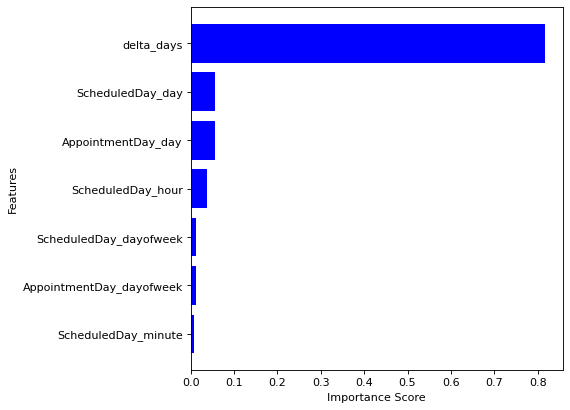

In [18]:
feature_importances = pd.DataFrame(rf_normal.feature_importances_,
index = col2use_normal,
columns=["importance"]).sort_values("importance",
ascending=False)
num = min([50,len(col2use_normal)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor="w", edgecolor="k")
plt.barh(ylocs, values_to_plot, align = "center", color=cmap(0.))
plt.ylabel("Features")
plt.xlabel("Importance Score")
# plt.title("Feature Importance Score — Random Forest - Normal")
plt.yticks(ylocs, feature_labels)
plt.show()

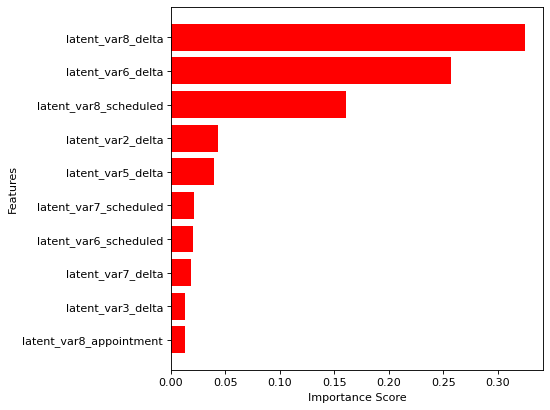

In [19]:
feature_importances = pd.DataFrame(rf_only_embed.feature_importances_,
index = col2use_only_embed,
columns=["importance"]).sort_values("importance",
ascending=False)

feature_importances = feature_importances[:10]

num = min([50,len(feature_importances)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor="w", edgecolor="k")
plt.barh(ylocs, values_to_plot, align = "center", color=cmap(1.))
plt.ylabel("Features")
plt.xlabel("Importance Score")
# plt.title("Feature Importance Score — Random Forest - Only Embeddings")
plt.yticks(ylocs, feature_labels)
plt.show()

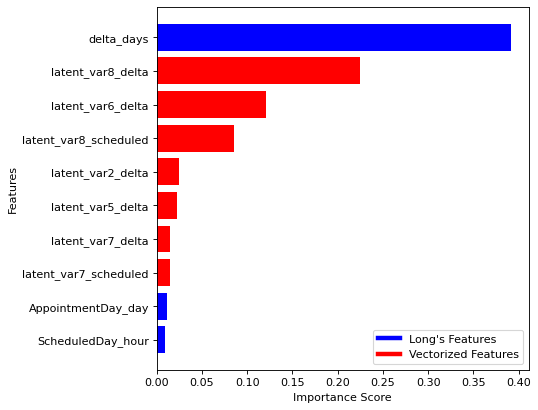

In [20]:
feature_importances = pd.DataFrame(rf_normal_embed.feature_importances_,
index = col2use_normal_embed,
columns=["importance"]).sort_values("importance",
ascending=False)

feature_importances = feature_importances[:10]

num = min([50,len(feature_importances)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

c = []
for label in feature_labels:
    if "latent" in label:
        c.append(cmap(1.))
    else:
        c.append(cmap(0.))

plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor="w", edgecolor="k")
plt.barh(ylocs, values_to_plot, align = "center", color=c)
plt.ylabel("Features")
plt.xlabel("Importance Score")
# plt.title("Feature Importance Score — Random Forest - Normal and Embeddings")
plt.yticks(ylocs, feature_labels)
plt.legend(custom_lines, ['Long\'s Features', 'Vectorized Features'])
plt.show()